In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 12.2 MB/s eta 0:00:00


In [3]:
import requests
from pathlib import Path

# Downloading helper functions from learn-pytorch repo
if Path('helper_function.py').is_file():
  print('File Exist')
else:
  print('Downloading Helper Function!')
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)

In [4]:
from helper_functions import plot_decision_boundary
import torchmetrics

##**Generate our Spiral Data (from scratch)**

In [5]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 500 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.long)

In [6]:
X[:5], X.shape, y[:5], y.shape

(tensor([[-0.0000e+00,  0.0000e+00],
         [-3.5308e-06,  2.0040e-03],
         [ 1.7053e-03,  3.6272e-03],
         [ 2.9979e-05,  6.0119e-03],
         [-2.6029e-03,  7.5817e-03]]),
 torch.Size([1500, 2]),
 tensor([0, 0, 0, 0, 0]),
 torch.Size([1500]))

##**Splitting into Train and test sets**

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1200, 2]),
 torch.Size([300, 2]),
 torch.Size([1200]),
 torch.Size([300]))

In [8]:
X_train.dtype, y_train.dtype

(torch.float32, torch.int64)

##**Plotting our Data (getting visual..)**

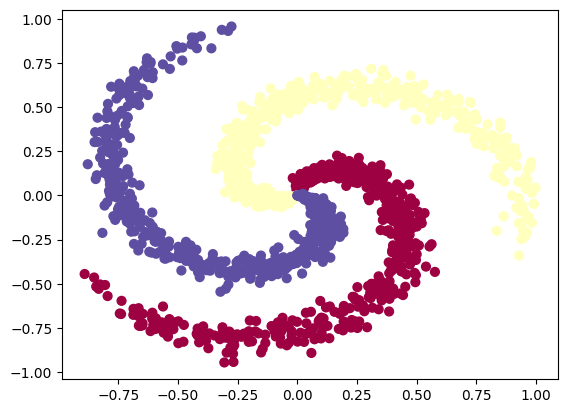

In [9]:
# Lets Visualize our data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap = plt.cm.Spectral)
plt.show()

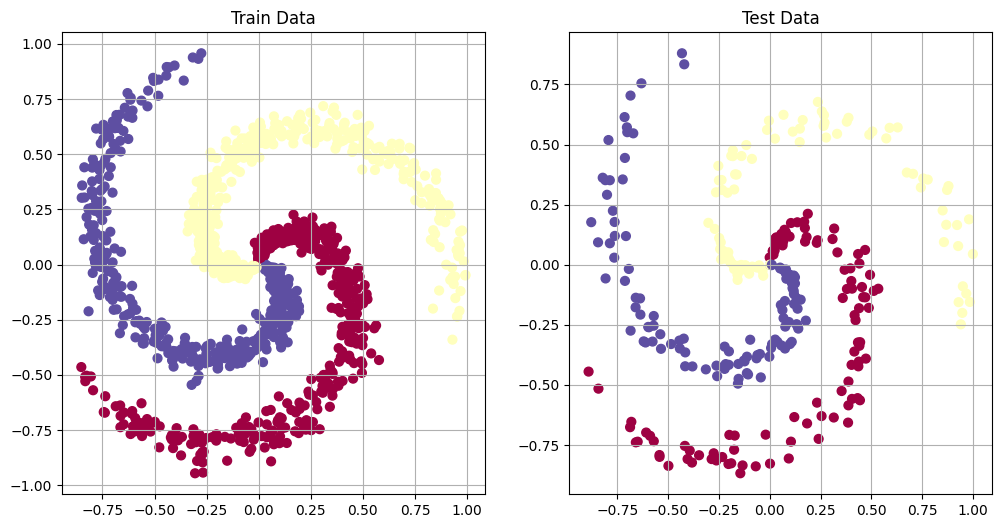

In [10]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title('Train Data')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s = 40, cmap=plt.cm.Spectral)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Test Data')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=40, cmap = plt.cm.Spectral)
plt.grid()
plt.show()

##**Construct a PyTorch model**

In [11]:
# Check if the GPU is available or not
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [71]:
from torch import nn

class SpiralModel(nn.Module):
  def __init__(self):
    super().__init__()
    # Create a linear stack of layers
    self.linear_stack = nn.Sequential(
        nn.Linear(in_features=2, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=32),
        nn.ReLU(),
        nn.Linear(in_features=32, out_features=3),
    )

  def forward(self, X:torch.tensor) -> torch.tensor:
    return self.linear_stack(X)

In [72]:
model = SpiralModel().to(device)
model

SpiralModel(
  (linear_stack): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=3, bias=True)
  )
)

##**Set up Loss function, Optimizer and accuracy function**

In [73]:
# Loss Function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(params = model.parameters(),
                            lr = 0.1)

##**Making predictions with our model**

In [74]:
with torch.inference_mode():
  y_logits = model(X_test.to(device))
y_logits[:5]

tensor([[ 0.1238, -0.0922, -0.1889],
        [ 0.1239, -0.0758, -0.1525],
        [ 0.1537, -0.1142, -0.1794],
        [ 0.1500, -0.1121, -0.1834],
        [ 0.1541, -0.1098, -0.1676]], device='cuda:0')

In [75]:
y_probs = torch.softmax(y_logits, dim = 1)
y_probs[:5]

tensor([[0.3941, 0.3176, 0.2883],
        [0.3880, 0.3177, 0.2943],
        [0.4029, 0.3083, 0.2888],
        [0.4023, 0.3095, 0.2882],
        [0.4011, 0.3081, 0.2908]], device='cuda:0')

In [76]:
y_preds = torch.argmax(y_probs, dim = 1)
y_preds

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [77]:
# Calculate accuracy - out of 100 how many correct ones did our model get
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = correct / len(y_pred) * 100
  return acc

##**Building a Training & Testing Loop for our model**

In [78]:
EPOCHS = 1000

# Set up loss and epoch tracking variables
epoch_list = []
train_loss_val, test_loss_val = [], []

# Convert data to use GPU (for faster computations)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Iterate through epochs
for epoch in range(EPOCHS):
  # Set model to train
  model.train()

  # Forward Propagation
  y_logits = model(X_train)
  y_preds = torch.softmax(y_logits, dim = 1).argmax(dim = 1)

  # Calculate loss and accuracy
  train_loss = loss_fn(y_logits, y_train)
  train_acc = accuracy_fn(y_train, y_preds)

  # Clear all gradient calculations from previous epoch
  optimizer.zero_grad()
  # Backpropagation
  train_loss.backward()
  # Gradient-Descent
  optimizer.step()

  # Make predictions and calculate test loss and accuracy
  model.eval()
  with torch.inference_mode():
    test_logits = model(X_test)
    test_preds = torch.softmax(test_logits, dim = 1).argmax(dim = 1)

    test_loss = loss_fn(test_logits, y_test)
    test_accuracy = accuracy_fn(test_loss, test_preds)

  # Update Epoch, loss value to tracking variables
  epoch_list.append(epoch)
  train_loss_val.append(train_loss.cpu().detach().numpy())
  test_loss_val.append(test_loss.cpu().detach().numpy())

  if epoch % 100 == 0:
    print(f'Epoch: {epoch} | Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:2f} | Test loss: {test_loss:.5f} | Test Accuracy: {test_accuracy:.2f}')

Epoch: 0 | Train Loss: 1.09857 | Train Accuracy: 33.000000 | Test loss: 1.09749 | Test Accuracy: 0.00
Epoch: 100 | Train Loss: 0.78727 | Train Accuracy: 57.000000 | Test loss: 0.78809 | Test Accuracy: 0.00
Epoch: 200 | Train Loss: 0.60525 | Train Accuracy: 62.750000 | Test loss: 0.62274 | Test Accuracy: 0.00
Epoch: 300 | Train Loss: 0.48480 | Train Accuracy: 76.250000 | Test loss: 0.49426 | Test Accuracy: 0.00
Epoch: 400 | Train Loss: 0.32435 | Train Accuracy: 90.416667 | Test loss: 0.32359 | Test Accuracy: 0.00
Epoch: 500 | Train Loss: 0.16480 | Train Accuracy: 94.166667 | Test loss: 0.15676 | Test Accuracy: 0.00
Epoch: 600 | Train Loss: 0.11154 | Train Accuracy: 96.166667 | Test loss: 0.09691 | Test Accuracy: 0.00
Epoch: 700 | Train Loss: 0.08262 | Train Accuracy: 97.416667 | Test loss: 0.06700 | Test Accuracy: 0.00
Epoch: 800 | Train Loss: 0.06567 | Train Accuracy: 98.250000 | Test loss: 0.05062 | Test Accuracy: 0.00
Epoch: 900 | Train Loss: 0.05401 | Train Accuracy: 98.666667 | Tes

##**Evaluating our PyTorch model**

In [79]:
with torch.inference_mode():
  y_logits = model(X_test)
y_preds = torch.argmax(torch.softmax(y_logits, dim = 1), dim = 1)
y_preds[:10]

tensor([2, 2, 0, 0, 0, 1, 2, 1, 2, 0], device='cuda:0')

In [80]:
y_test[:10]

tensor([2, 2, 0, 0, 0, 1, 2, 1, 2, 0], device='cuda:0')

In [81]:
print(f'Test Loss: {loss_fn(y_logits, y_test)}')
print(f'Test Accuracy: {accuracy_fn(y_test, y_preds)}')

Test Loss: 0.028848053887486458
Test Accuracy: 99.66666666666667


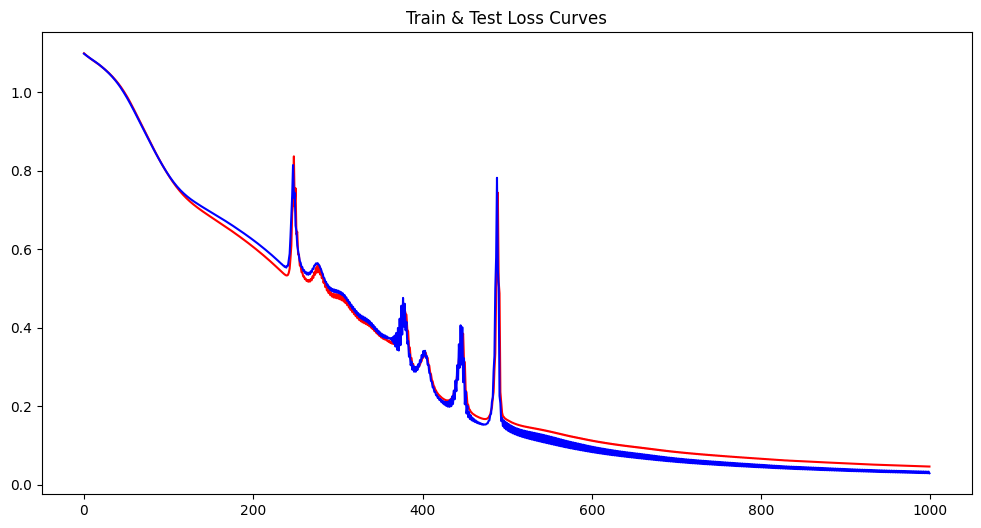

In [82]:
plt.figure(figsize=(12, 6))
plt.title('Train & Test Loss Curves')
plt.plot(epoch_list, train_loss_val, label='Train loss', c='red')
plt.plot(epoch_list, test_loss_val, label='Test Loss', c='blue')
plt.show()

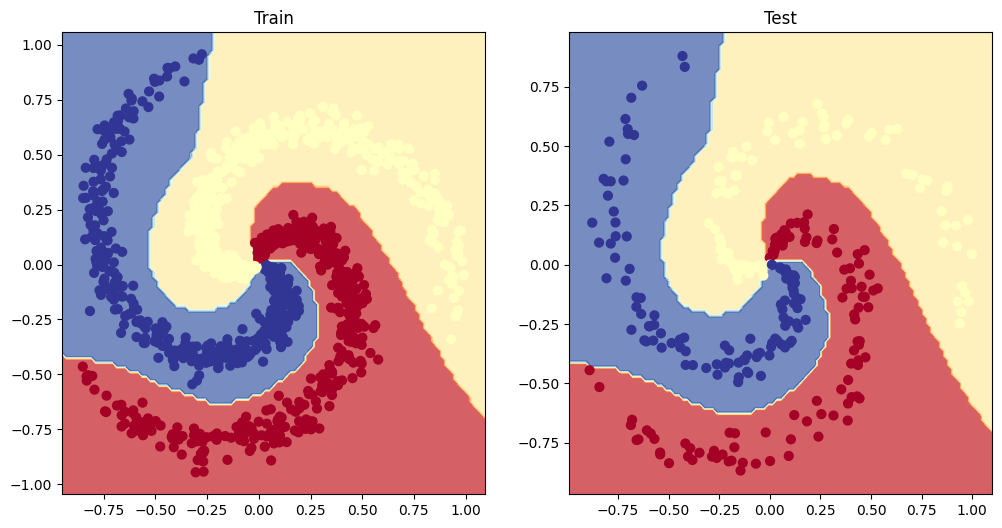

In [83]:
# plot decision boundary of model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model, X_test, y_test)

In [84]:
from torchmetrics import Accuracy, Precision, Recall, F1Score

def torch_metrics(preds, target):

  torchmetric_acc = Accuracy(task="multiclass", num_classes=4).to(device)
  acc = torchmetric_acc(preds, target)

  torchmetric_precision = Precision(task="multiclass", num_classes=4, average='macro').to(device)
  precision = torchmetric_precision(preds, target)

  torchmetric_recall = Recall(task="multiclass", num_classes=4, average='macro').to(device)
  recall = torchmetric_recall(preds, target)

  torchmetric_f1 = F1Score(task="multiclass", num_classes=4, average='macro').to(device)
  f1 = torchmetric_f1(preds, target)

  return acc, precision, recall, f1

acc, prec, recall, f1_score = torch_metrics(preds=y_preds, target=y_test)
print(f'Accuracy: {acc*100}% \nPrecision: {prec*100}% \nRecall: {recall*100}% \nF1 Score: {f1_score*100}%')

Accuracy: 99.66666412353516% 
Precision: 99.69969940185547% 
Recall: 99.6124038696289% 
F1 Score: 99.65424346923828%


##**Saving and re-loading our model**

In [85]:
# saving our spiral mutliclass classification PyTorch model
torch.save(model.state_dict(), "spiral_classification_model.pt")

In [87]:
# loading our model
loaded_model = SpiralModel().to(device)
loaded_model.load_state_dict(torch.load("spiral_classification_model.pt"))

<All keys matched successfully>

In [88]:
with torch.inference_mode():
  loaded_y_preds = torch.argmax(torch.softmax(loaded_model(X_test), dim=1), dim=1)
loaded_y_preds == y_preds

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

In [89]:
acc, prec, recall, f1_score = torch_metrics(preds=y_preds, target=y_test)
print(f'Accuracy: {acc*100}% \nPrecision: {prec*100}% \nRecall: {recall*100}% \nF1 Score: {f1_score*100}%')

Accuracy: 99.66666412353516% 
Precision: 99.69969940185547% 
Recall: 99.6124038696289% 
F1 Score: 99.65424346923828%
